In [28]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from glob import glob
# from PIL import Image
from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [ ]:
wavelengths = [647, 561, 488]  # nm
NA = 1.25
nm_per_pixel = 108

In [30]:
def get_mu_sigma(filename: str) -> tuple[float, float]:
    with open(filename, 'r') as f:
        contents = f.readlines()
    
    mu = float(contents[-2].split(' = ')[-1][:-1])
    sigma = float(contents[-1].split(' = ')[-1][:-1])
    return mu, sigma

In [44]:
print("Means\tStd\tTheoretical PSF\tx")
for i, wavelen in enumerate(wavelengths):
    x_mus = np.zeros(10)
    x_sigmas = np.zeros(10)
    for j, log in enumerate(glob(f'../data/Acquisition-{i+1}/analysis/Log*.txt')):
        mu, sigma = get_mu_sigma(log)
        x_mus[j] = mu*nm_per_pixel
        x_sigmas[j] = sigma*nm_per_pixel
    print(np.mean(x_mus).round(2), np.mean(x_sigmas).round(2), 0.21 * wavelen / NA)

print("")
print("Means\tStd\tTheoretical PSF\ty")
for i, wavelen in enumerate(wavelengths):
    y_mus = np.zeros(10)
    y_sigmas = np.zeros(10)
    for j, log in enumerate(glob(f'../data/Acquisition-{i+1}/analysis-y/Log*.txt')):
        mu, sigma = get_mu_sigma(log)
        y_mus[j] = mu*nm_per_pixel
        y_sigmas[j] = sigma*nm_per_pixel
    print(np.mean(y_mus).round(2), np.mean(y_sigmas).round(2), 0.21 * wavelen / NA)


Means	Std	Theoretical PSF	x
540.15 207.09 108.696
388.94 166.09 94.248
432.49 167.83 81.984

Means	Std	Theoretical PSF	y
372.73 217.27 108.696
240.93 132.22 94.248
352.11 166.93 81.984


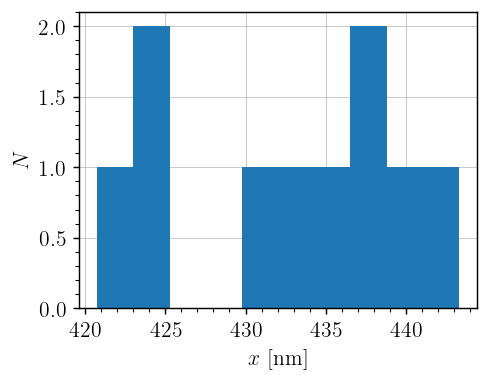

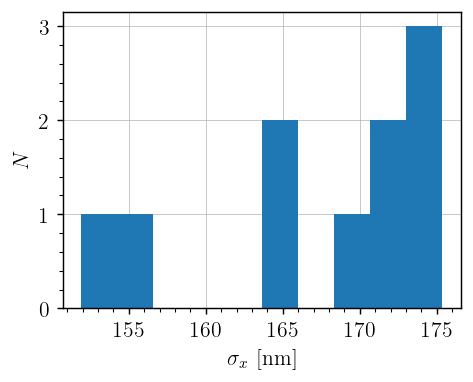

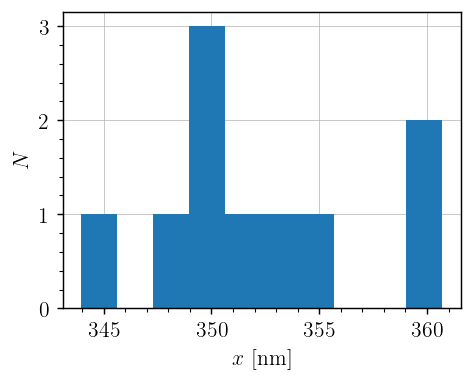

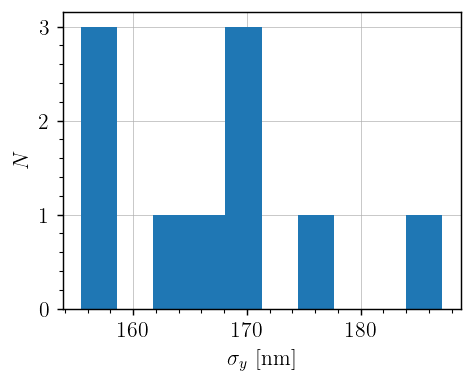

In [47]:
plt.hist(x_mus)
plt.xlabel("$x$ [nm]")
plt.ylabel("$N$")
plt.show()
plt.hist(x_sigmas)
plt.xlabel(r"$\sigma_x$ [nm]")
plt.ylabel("$N$")
plt.show()
plt.hist(y_mus)
plt.xlabel("$x$ [nm]")
plt.ylabel("$N$")
plt.show()
plt.hist(y_sigmas)
plt.xlabel(r"$\sigma_y$ [nm]")
plt.ylabel("$N$")
plt.show()

In [33]:
# im = Image.open('../data/Acquisition-1/image_Nano-2D(15nmPix).tif')
# imarray = np.array(im)
# imarray, im.size

In [34]:
# a = plt.imread('../data/Acquisition-1/image_Nano-2D(15nmPix).tif')
# plt.imshow(a[..., 0])